<a href="https://colab.research.google.com/github/ozakiryota/kaggle/blob/main/houseprices_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downlad and check datasets

Activate Kaggle API

In [78]:
from google.colab import files
import os

jason_path = "/root/.kaggle/kaggle.json"

if not os.path.exists(jason_path):
    uploaded = files.upload()

    for fn in uploaded.keys():
        print("User uploaded file '{name}' with length {length} bytes".format(
            name=fn, length=len(uploaded[fn])))

    # Then move kaggle.json into the folder where the API expects to find it.
    !mkdir -p /root/.kaggle/ && mv kaggle.json /root/.kaggle/ && chmod 600 /root/.kaggle/kaggle.json

else:
    print(jason_path, "is already exists.")

/root/.kaggle/kaggle.json is already exists.


Download the datasets

In [79]:
!pip install kaggle
!kaggle competitions download -c house-prices-advanced-regression-techniques

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)


Check the datasets

In [80]:
import pandas as pd

df = pd.read_csv("/content/train.csv")
# df = pd.read_csv("/content/test.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Fuctions and class

In [81]:
import pandas as pd

def makeDataList(csv_path):
    datalist = pd.read_csv(csv_path)
    datalist = datalist.drop(["Id"], axis=1)
    datalist = pd.get_dummies(datalist)
    datalist = datalist.fillna(-1)

    return datalist

In [82]:
## TEST
datalist = makeDataList("/content/train.csv")
print("datalist.columns =", datalist.columns)
print("datalist.values[0] =", datalist.values[0])
print(datalist)

datalist.columns = Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=289)
datalist.values[0] = [6.000e+01 6.500e+01 8.450e+03 7.000e+00 5.000e+00 2.003e+03 2.003e+03
 1.960e+02 7.060e+02 0.000e+00 1.500e+02 8.560e+02 8.560e+02 8.540e+02
 0.000e+00 1.710e+03 1.000e+00 0.000e+00 2.000e+00 1.000e+00 3.000e+00
 1.000e+00 8.000e+00 0.000e+00 2.003e+03 2.000e+00 5.480e+02 0.000e+00
 6.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
 2.008e+03 2.085e+05 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 0

In [83]:
## TEST
from sklearn.model_selection import train_test_split

train_datalist, val_datalist = train_test_split(datalist, test_size=0.1, random_state=1234, shuffle=True)
print(train_datalist)
print(val_datalist)

      MSSubClass  LotFrontage  ...  SaleCondition_Normal  SaleCondition_Partial
299           20         80.0  ...                     0                      0
235          160         21.0  ...                     1                      0
69            50         81.0  ...                     1                      0
507           20         75.0  ...                     0                      1
31            20         -1.0  ...                     1                      0
...          ...          ...  ...                   ...                    ...
1228         120         65.0  ...                     0                      1
1077          20         -1.0  ...                     0                      0
1318          20         -1.0  ...                     1                      0
723           50         60.0  ...                     1                      0
815           20         48.0  ...                     1                      0

[1314 rows x 289 columns]
      MSSubCl

In [84]:
import numpy as np

import torch.utils.data as data

class Dataset(data.Dataset):
    def __init__(self, datalist):
        self.datalist = datalist

    def __len__(self):
        return len(self.datalist.values)
    
    def __getitem__(self, index):
        inputs = self.datalist.drop(["SalePrice"], axis=1).values[index].astype(np.float32)
        labels = self.datalist["SalePrice"].values[index].astype(np.float32)
        return inputs, labels

In [85]:
## TEST
dataset = Dataset(datalist)
print("dataset.__len__() =", dataset.__len__())
print("dataset.__getitem__(index=0)[0] =", dataset.__getitem__(index=0)[0])
print("dataset.__getitem__(index=0)[1] =", dataset.__getitem__(index=0)[1])

dataset.__len__() = 1460
dataset.__getitem__(index=0)[0] = [6.000e+01 6.500e+01 8.450e+03 7.000e+00 5.000e+00 2.003e+03 2.003e+03
 1.960e+02 7.060e+02 0.000e+00 1.500e+02 8.560e+02 8.560e+02 8.540e+02
 0.000e+00 1.710e+03 1.000e+00 0.000e+00 2.000e+00 1.000e+00 3.000e+00
 1.000e+00 8.000e+00 0.000e+00 2.003e+03 2.000e+00 5.480e+02 0.000e+00
 6.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
 2.008e+03 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+

In [86]:
## TEST
import torch

batch_size = 10
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
batch_itr = iter(dataloader)
inputs, labels = next(batch_itr)

print("inputs = ", inputs)
print("inputs.size() = ", inputs.size())
print("labels = ", labels)
print("labels.size() = ", labels.size())

inputs =  tensor([[ 2.0000e+01, -1.0000e+00,  3.6500e+04,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [ 5.0000e+01,  6.0000e+01,  8.4000e+03,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [ 2.0000e+01,  7.4000e+01,  8.5320e+03,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        ...,
        [ 1.6000e+02,  2.4000e+01,  2.0160e+03,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [ 3.0000e+01,  5.0000e+01,  9.3400e+03,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [ 6.0000e+01, -1.0000e+00,  9.6360e+03,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00]])
inputs.size() =  torch.Size([10, 288])
labels =  tensor([190000., 140000., 153000., 305900., 130000., 119000., 176000., 106000.,
        113000., 178000.])
labels.size() =  torch.Size([10])


In [87]:
from torch import nn

class Network(nn.Module):
    def __init__(self, fc_dim_list, dropout_rate):
        super().__init__()

        layer_list = []
        for i in range(len(fc_dim_list) - 1):
            layer_list.append(nn.Linear(fc_dim_list[i], fc_dim_list[i+1]))
            layer_list.append(nn.ReLU(inplace=True))
            if i != len(fc_dim_list) - 2:
                layer_list.append(nn.Dropout(p=dropout_rate))
        self.fc = nn.Sequential(*layer_list)

    def forward(self, x):
        x = self.fc(x)
        return x

In [88]:
## TEST
net = Network([len(dataset.__getitem__(index=0)[0]), 256, 128, 64, 1], dropout_rate=0.1)
print(net)
outputs = net(inputs)
print("outputs = ", outputs)
print(outputs.size())

Network(
  (fc): Sequential(
    (0): Linear(in_features=288, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): ReLU(inplace=True)
  )
)
outputs =  tensor([[ 0.0000],
        [ 0.0000],
        [ 3.7313],
        [19.7764],
        [18.7449],
        [ 9.3916],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 1.9882]], grad_fn=<ReluBackward0>)
torch.Size([10, 1])


# Training

self.device =  cuda:0
Network(
  (fc): Sequential(
    (0): Linear(in_features=288, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): ReLU(inplace=True)
  )
)
----------
Epoch 1/200
train Loss: 20809127257.2298
val Loss: 3614693547.8356
----------
Epoch 20/200
train Loss: 2400835969.5586
val Loss: 1416409417.6438
----------
Epoch 40/200
train Loss: 2011566027.3973
val Loss: 1350694272.0000
----------
Epoch 60/200
train Loss: 1775876320.2435
val Loss: 1294423683.5068
----------
Epoch 80/200
train Loss: 2114520752.5114
val Loss: 1459778610.8493
----------
Epoch 100/200
train Loss: 1911885554.9467
val Loss: 1939565522.4110


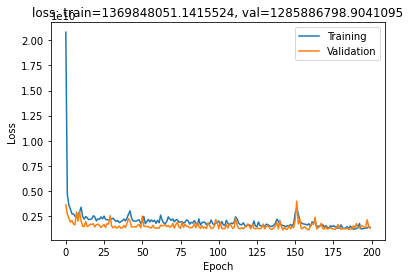

In [89]:
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim

class Trainer:
    def __init__(self, csv_path, num_epochs, batch_size, lr, save_weights_path):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("self.device = ", self.device)
        
        datalist = makeDataList(csv_path)
        train_datalist, val_datalist = train_test_split(datalist, test_size=0.1, random_state=1234, shuffle=True)
        train_dataset = Dataset(train_datalist)
        val_dataset = Dataset(val_datalist)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
        
        self.num_epochs = num_epochs
        self.dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
        self.net = Network([len(train_dataset.__getitem__(index=0)[0]), 256, 128, 64, 1], dropout_rate=0.1)
        self.net.to(self.device)
        print(net)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)

    def train(self):
        ## time
        start_clock = time.time()
        ## record
        record_train_loss = []
        record_val_loss = []
        record_loss_dict = {"train": [], "val": []}
        min_loss_epoch = 0.0
        ## loop
        for epoch in range(self.num_epochs):
            if epoch == 0 or not (epoch+1) % (num_epochs // 10):
                print("----------")
                print("Epoch {}/{}".format(epoch+1, self.num_epochs))
            ## phase
            for phase in ["train", "val"]:
                ## setting
                if phase == "train":
                    self.net.train()
                else:
                    self.net.eval()
                ## record
                loss_epoch = 0.0
                for inputs, labels in self.dataloaders_dict[phase]:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    labels.unsqueeze_(1)
                    ## reset gradient
                    self.optimizer.zero_grad()
                    ## switch computing gradient
                    with torch.set_grad_enabled(phase == "train"):
                        ## forward
                        outputs = self.net(inputs)
                        loss = self.criterion(outputs, labels)
                        ## backward
                        if phase == "train":
                            loss.backward()
                            self.optimizer.step()
                    ## add loss
                    loss_epoch += loss.item() * inputs.size(0)
                ## average loss
                loss_epoch = loss_epoch / len(self.dataloaders_dict[phase].dataset)
                record_loss_dict[phase].append(loss_epoch)
                if epoch == 0 or not (epoch+1) % (num_epochs // 10):
                    print("{} Loss: {:.4f}".format(phase, loss_epoch))
            ## save
            if epoch == 0 or record_loss_dict["val"][-1] < min_loss_epoch:
                min_loss_epoch = record_loss_dict["val"][-1]
                torch.save(self.net.state_dict(), save_weights_path)
        ## time
        mins = (time.time() - start_clock) // 60
        secs = (time.time() - start_clock) % 60
        print ("training time: ", mins, " [min] ", secs, " [sec]")
        ## graph
        self.showGraph(record_loss_dict)

    def showGraph(self, record_loss_dict):
        graph = plt.figure()
        plt.plot(range(len(record_loss_dict["train"])), record_loss_dict["train"], label="Training")
        plt.plot(range(len(record_loss_dict["val"])), record_loss_dict["val"], label="Validation")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("loss: train=" + str(record_loss_dict["train"][-1]) + ", val=" + str(record_loss_dict["val"][-1]))
        plt.show()


csv_path = "/content/train.csv"
num_epochs = 200
batch_size = 100
lr = 0.01
save_weights_path = "/content/weights.pth"

trainer = Trainer(csv_path, num_epochs, batch_size, lr, save_weights_path)
trainer.train()

# Evaluation

In [90]:
import time
import pandas as pd

import torch

class Evaluator:
    def __init__(self, train_csv_path, eval_csv_path, weights_path, save_csv_path):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("self.device = ", self.device)

        #self.csv_path = csv_path
        self.save_csv_path = save_csv_path
        self.datalist = self.makeEvalDataList(train_csv_path, eval_csv_path)

        self.net = Network([self.datalist.shape[1]-1, 256, 128, 64, 1], dropout_rate=0.1)
        self.net.to(self.device)
        if torch.cuda.is_available():
            loaded_weights = torch.load(weights_path)
            print("Weights have been loaded [GPU -> GPU]:", weights_path)
        else:
            loaded_weights = torch.load(weights_path, map_location={"cuda:0": "cpu"})
            print("Weights have been loaded [GPU -> CPU]:", weights_path)
        self.net.load_state_dict(loaded_weights)
        print(self.net)

    def makeEvalDataList(self, train_csv_path, eval_csv_path):
        train_datalist = pd.read_csv(train_csv_path)
        eval_datalist = pd.read_csv(eval_csv_path)
        datalist = pd.concat([train_datalist, eval_datalist], ignore_index=True)
        datalist = pd.get_dummies(datalist)
        datalist = datalist.loc[datalist["SalePrice"].isna()]
        datalist = datalist.drop(["SalePrice"], axis=1)
        datalist = datalist.fillna(-1)
        return datalist

    def evaluate(self):
        ## time
        start_clock = time.time()
        ## setting
        self.net.eval()
        ## ndarray -> tensor
        inputs = torch.from_numpy(self.datalist.drop(["Id"], axis=1).values.astype(np.float32))
        inputs = inputs.to(self.device)
        ## forward
        with torch.no_grad():
            outputs = self.net(inputs)
            outputs.squeeze_(1)
        ## save
        self.writeCSV(outputs)
        ## time
        mins = (time.time() - start_clock) // 60
        secs = (time.time() - start_clock) % 60
        print ("evaluation time: ", mins, " [min] ", secs, " [sec]")

    def writeCSV(self, outputs):
        result_df = pd.DataFrame({"Id": self.datalist["Id"].values, "SalePrice": outputs.cpu().detach().numpy()})
        result_df.to_csv(self.save_csv_path, index=False)
        print(result_df)


train_csv_path = "/content/train.csv"
eval_csv_path = "/content/test.csv"
weights_path = "/content/weights.pth"
save_csv_path = "/content/submission.csv"

evaluator = Evaluator(train_csv_path, eval_csv_path, weights_path, save_csv_path)
evaluator.evaluate()

self.device =  cuda:0
Weights have been loaded [GPU -> GPU]: /content/weights.pth
Network(
  (fc): Sequential(
    (0): Linear(in_features=288, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): ReLU(inplace=True)
  )
)
        Id      SalePrice
0     1461  147957.031250
1     1462  152180.296875
2     1463  203196.312500
3     1464  212292.859375
4     1465  188582.875000
...    ...            ...
1454  2915   87423.039062
1455  2916   99784.359375
1456  2917  186025.000000
1457  2918  106498.132812
1458  2919  236252.031250

[1459 rows x 2 columns]
evaluation time:  0.0  [min]  0.01674509048461914  [sec]


# Submission

In [91]:
import sys

print("Submit the file? (y/n)")
ans = input()
while ans != "y" and ans != "n":
    print("Type 'y' or 'n'")
    ans = input()
if ans == "y":
    !kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "houseprices_regression.ipynb"

Submit the file? (y/n)
y
100% 21.2k/21.2k [00:01<00:00, 14.2kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques